<b>Author: Christian Camilo Urcuqui López

Date: 6 december 2018

</b>

<img src="../../PyTorch/assets/conv_net.jpg" width="700" />


# Convolutional Neural Networks 

They are important neural network architecture to resolve problems related with data with more 2D, for example image processing. 

One important thing to make is to normalize each image, because it helps these gradient calculations stay consistent, for example if we have a resolution of 255 we must divide each pixel to this number and we will have a number between zero to one.

Once we have the data normalized the idea is to apply a flattening process (in other words to change the shape or reshape) 

Let's remember the NMIST dataset of handwritten digits, you can see more information in it's 
<a href='../../Deep Learning/notMNIST.ipynb'>Link</a>

+ [NMIST](#NMIST)
+ [Framework on CNN](#Framework-on-CNN)
+ [Convolutional Neural Layer](#Convolutional-Neural-Layer)
    + [Filters](#Filters)
    + [Pooling layer](#Pooling-layer)
+ [CNN on Pytorch](#CNN-on-Pytorch)
+ [ImageNet](#ImageNet)
+ [How convolutional neural networks see the world](#How-convolutional-neural-networks-see-the-world)
+ [References](#References)


## NMIST

In [7]:
from IPython.display import display, Image
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # TODO: compose transforms here
dataset = datasets.MNIST('../../../Datasets/MNIST_data/', download=True, transform=transform)

In [23]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../../../Datasets/MNIST_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [11]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

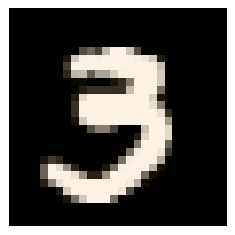

In [16]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True) # TODO: use the ImageFolder
images, labels = next(iter(dataloader))
imshow(images[0], normalize=True)

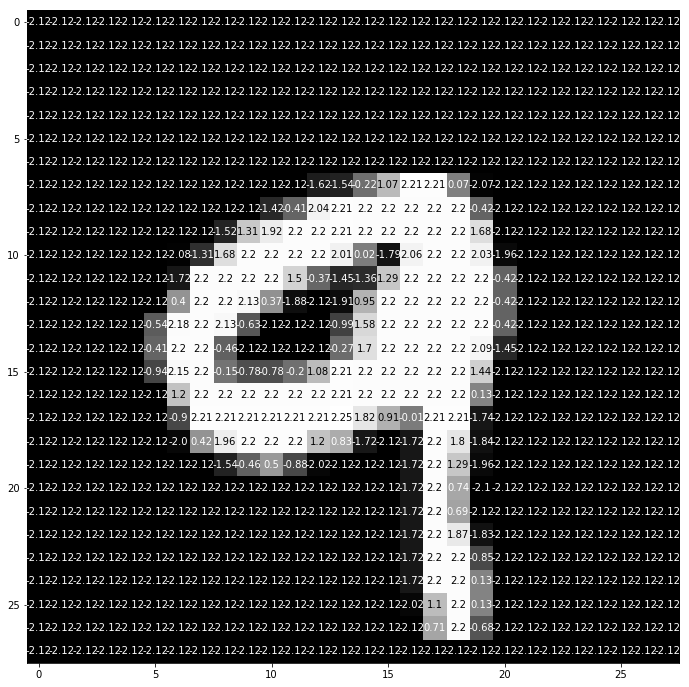

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

images = images.numpy()

img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

As you can see we have a image composed by gray pixels, so the next idea is to flatten them.

In [25]:
images = torch.from_numpy(images)
images[0].shape

torch.Size([1, 28, 28])

In [26]:
new_img = images[0].view(1,784)
new_img.shape

torch.Size([1, 784])

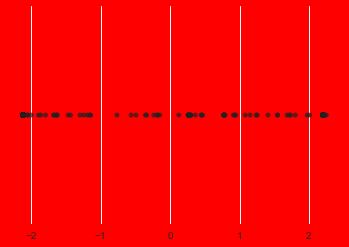

In [66]:
import seaborn as sns

image = new_img.numpy().transpose()
sns.set(rc={'axes.facecolor':'red', 'figure.facecolor':'red'})
sns.stripplot(image, palette=sns.dark_palette((260, 75, 60), input="husl"), alpha=0.7)


Through the flattening process, we got a vector composed by the gray pixels, each of them is going to be an input for a neural network, and the aim of the model is to discover the pattern behind the training data

In [4]:
num_workers = 0 # if you want to load data in parallel
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # TODO: compose transforms here
train_data = datasets.MNIST('../../../Datasets/MNIST_data/', download=True, transform=transform, train=True)
test_data = datasets.MNIST('../../../Datasets/MNIST_data/', download=True, transform=transform, train=False)

# obtain training indices that will be used for validation 
num_train = len(train_data)
indices = list(range(num_train))
np.random.seed(7)
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx =  indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler =train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler= valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers=num_workers)

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 392) 
        self.fc3 = nn.Linear(392, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activatiojn function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        x = F.log_softmax(self.fc3(x), dim=1)
        return x    

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [20]:
model = Network()
model.to(device)
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print_every = 5
# number of epochs to train the model
n_epochs = 50
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity


for e in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    running_loss = 0
    model.train() # prep model for training
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels =  images.to(device), labels.to(device)        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
       
    ######################    
    # validate the model #
    ######################  
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        data, target =  data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.383120 	Validation Loss: 0.052495
Validation loss decreased (inf --> 0.052495).  Saving model ...
Epoch: 2 	Training Loss: 0.185646 	Validation Loss: 0.036630
Validation loss decreased (0.052495 --> 0.036630).  Saving model ...
Epoch: 3 	Training Loss: 0.136148 	Validation Loss: 0.029274
Validation loss decreased (0.036630 --> 0.029274).  Saving model ...
Epoch: 4 	Training Loss: 0.111077 	Validation Loss: 0.025398
Validation loss decreased (0.029274 --> 0.025398).  Saving model ...
Epoch: 5 	Training Loss: 0.095940 	Validation Loss: 0.021952
Validation loss decreased (0.025398 --> 0.021952).  Saving model ...
Epoch: 6 	Training Loss: 0.080429 	Validation Loss: 0.020622
Validation loss decreased (0.021952 --> 0.020622).  Saving model ...
Epoch: 7 	Training Loss: 0.072261 	Validation Loss: 0.022593
Epoch: 8 	Training Loss: 0.064921 	Validation Loss: 0.018561
Validation loss decreased (0.020622 --> 0.018561).  Saving model ...
Epoch: 9 	Training Loss: 0.059224 

### Load the Model with the Lowest Validation Loss

In [21]:
model.load_state_dict(torch.load('model.pt'))

In [22]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    
    data, target =  data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.064224

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 96% (864/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 98% (957/974)
Test Accuracy of     9: 96% (977/1009)

Test Accuracy (Overall): 98% (9812/10000)


tensor([-0.0000, -0.0000, -0.0002, -0.0000, -0.0001, -0.0001, -0.0000, -0.0010,
        -0.0296, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0010,
        -0.0001, -0.0000, -0.0005,  0.0000], grad_fn=<MaxBackward0>)

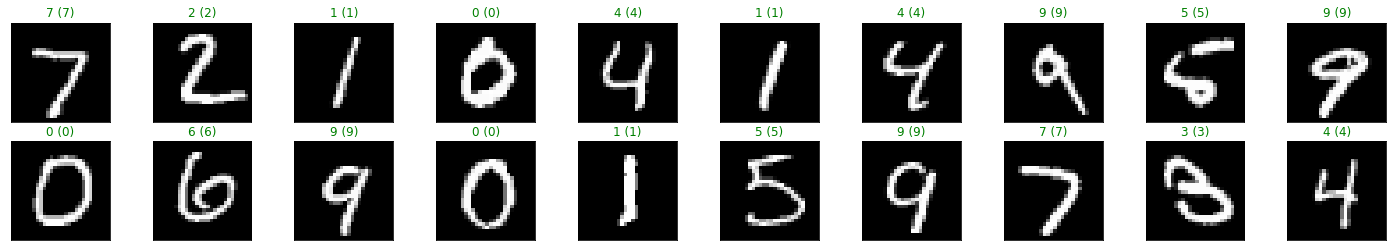

In [23]:
# the next code gets one batch of test images
detaiter = iter(test_loader)
model.eval()
model.to('cpu')
images, labels =  detaiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

#plot the images in the batch, along with predicted and true labels
fig =  plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

_

## Framework on CNN

We could define the next steps in order to evaluate different models to image image classification.

+ __Visualize Data__
+ __Pre-Process__. _Normalize Transform_
+ __Define a Model__. _Do your Research!_
+ __Train your model__. _Define loss & optimization functions_
+ __Save the Best Model__. _Consider using a validation dataset_
+ __Test your model__

## Convolutional Neural Layer

As we saw, a MLP is a good architecture with a good accuracy to resolve a problem related with a dataset like NMIST, but, this data doesn't have a lot of noice, for example all the digits are in the center of the picture and doesn't have any color, these characteristics can't be a problem for a MLP. 

CNN appears to resolve the problems mentioned becuase it allows us to analyze groups of pixels at a time and keep this information in something called the convolutional layer, this layer applies different filters also known as convolutional kernels to an input image, the filters may have extracted features like the edges of the object in the image or the colors.

One important difference between MLP and CNN is that each node on MLP's hidden layer is connected with their antecedents, instead, CNN are locally connected where their nodes are only connected to only a small subset of the previous layer's nodes.

### Filters 

When we are talking about patterns in a image we can ralate them with color or shape. 

Shape can also be thought of as patterns of a intensity in an image. With this idea in head we can talk about _frequency_, frequency in images is a __rate of change__. High frequency is related where the intensity changes a lot, and a low frequency image may be one that is relatively uniform in brithness or changes very slowly. 

High-frequency components are related with the edges of objects in images.

Filters are used to filter out unwanted or irrelevant information in an image or to amplify features 
+ High-pass filters
    + Sharpen an image
    + Enchance high-frequency parts of an image
    
Edges are areas in an image where the intensity changes very quickly, and they often indicate object boundaries

### Convolution Kernels

A kernel is a matrix of number that modifies an image, where the sum of all values is _zero_, and this is important because the idea is to compute the difference or change between neighboring pixels.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/4c694c500c1394918e437d9259fd10d8df3d9372/2-Figure2-1.png" width="700" />

So the idea is to apply to the function of an image $F(x,y)$ a convolution operation __*__.

$K*F(x,y)=$output image

The convolution operation represents who the filter pass behind the picture.


<img src="https://developer.apple.com/library/archive/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg" width="400" />

Perhaps the solution is interesting we must pay attention to one issue and this is what do you do if there are no surroinding pixels like on an image corner or edge?, in order to resolve this question we can apply three things:
+ __Extend__ the nearest border pixels are conceptually extended as far as neccesary to provide values for the convolution. 
+ __Padding__ The image is paddded with a border of 0's, black pixels
+ __Crop__  Any pixel in the output image which would requiere values from beyond the edge is skipped. 

The convolutional layer is produced by applying series of many different image filters, also known as convolutional kernels, to an input image.

<img src="notebook_ims/conv_layer.gif" width="800" />

We can see the application of the filters on a CNN in the next <a href='conv_visualization.ipynb'>Notebook</a>


### Stride & Padding 

Basically, _stride_ is the movement that each filter does in an image, and _padding_ is the way to add pixels (0's) around the borders in order to complete the convolutional process of each pixel. 

### Pooling layer

<img src='notebook_ims/CNN_all_layers.png' height=50% width=50% />

Pooling layers take convolutional layer as input in order to reduce the dimensionality, we can find different types:
+ ___Max pooling layer___, it itakes a stack of feature maps as input and calculates the maximum of the pixels contained in the window
+ ___Average pooling___, it chooses to average pixel values in a given window. This kind of pooling is typically not used for image classifcation problems because maxpooling is better at noticing the most important details about edges and other features in an image, but this is used in applications which smoothing an image is prefarable.


<img src='notebook_ims/maxpooling_ex.png' height=50% width=50% />
We can see the application of maxpooling in the next <a href='maxpooling_visualization.ipynb'>Notebook</a>

<img src='https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif' height=50% width=50% />

3x3 convolution with strides of 1


### Formula: Number of Parameters in a Convolutional Layer

We will have three variables in a convolutional layer, these are `filters/out_channels`, `kernel_size`, and `input_shape`. Let's define the next variables:
+ `K` - The number of filter in the convolutional layer.
+ `F` - The height and width of the convolutional filters
+ `D_in` - The depth of the previous layer

`k` = `out_channels`, and `F` =  `kernel_size`, `D_in` is the last value in the `input_shape` tuple, usually 1 or 3 (RGB and grayscale, respectively).

The total number of weights in the convolutional layer is `K*F*F*D_in`. We must add the bias term per filter, so the convolutional layer has `k` biases, then, the _number of parameters_ in the convolutional layer is given by `K*F*F*D_in + K`

### Formula: Shape of a Convolutional Layer

This shape depends on the parameters` kernel_size`, `input_shape`, `padding`, and `stride`. These are the varaibles:

+ `K` - The number of filter in the convolutional layer.
+ `F` - The height and width of the convolutional filters
+ `S` - the stride of the convolution
+ `P` - the padding
+ `W_in` - the width/height (square) of the previous layer

`k` = `out_channels`, and `F` =  `kernel_size`, and `S = stride`. Likewise, `W_in` is the first and second value of the `input_shape` tuple.

The depth of the convolutional layer will always equal the number of filters `K`.

The spatial dimensions of a convolutional layer can be calculated as: `(W_in−F+2P)/S+1`

### CNN Archirectures

By the last sections we can now mention that a CNN is an integration of Convolution layers plus Pooling layers and finally fully connected layers, I would like to mention some of the most valuable architectures proposed. 

__LeNet-5- A Classical CNN Architecture__
<img src="https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg" heigh="250">

__ALEXNET - Alex krizhevsky'12__
<img src="https://cdn-images-1.medium.com/max/1200/1*wzflNwJw9QkjWWvTosXhNw.png" heigh="250">

## CNN on Pytorch

We can define a convolutional layer in Pytorch through the next method and it's parameters.

```
self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
example:
self.conv1 = nn.Conv2d(3, 16, kernel_size, stride=1, padding=0)

```

For the last case, 3 is the depth of the input image and 16 is the depth of the convolutional layer, in other words, it is the number of __layers__ , the kernel size means the size of the filters that define a convolutional layer, for example, if we put 3 then we will have a filter of 3x3, stride and padding have default values, but should be set depending on how large you want your output to be in the spatial dimensions x, y

The mext method allows us to define a _maxpooling layer_

```
nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

```

In [1]:
# imoprt the Pytorch package
import torch.nn as nn

In [ ]:
def __init__(self):
        super(ModelName, self).__init__()
        self.features = nn.Sequential(
              nn.Conv2d(1, 16, 2, stride=2),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True),

              nn.Conv2d(16, 32, 3, padding=1),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True) 
         )

## ImageNet

The <a href="http://www.image-net.org/challenges/LSVRC/">ImageNet </a>Large Scale Visual Recognition Challenge (ILSVRC) evaluates algorithms for object detection and image classification at large scale, we can find around 1,000 different images categories. Through this anual event different architectures and research productions had been proposed, we saw that through a <a href="../../PyTorch/Part 8 - Transfer Learning (Exercises).ipynb">transfer learning </a>from these architectures and weights we can use them in order to propose new solutions, some of these architectures are:

+ AlexNet (2012, University of Toronto). Pioreered the use of the ReLU activation function and dropout as a technique for avoiding overfitting.
+ VGGNet (2014, Visual Geometry Group at Oxford University), we can find the versions VGG 16 and VGG 19 and their difference is the number of layers, they proposed a 3x3 convolutions broken up by 2x2 pooling layers and finished with 3 fully connected layers.
+ ResNet (2015, Microsoft Research) is kind of VGG but they connected a lot of VGG through the application of connections to their very deep CCNN that skip layers, this allows them to resolve the vanishing gradient's problem.

## How convolutional neural networks see the world


In [16]:
# code took from the reference 4
from __future__ import print_function

import numpy as np
import time
from keras.preprocessing.image import save_img
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        width_margin = (img_width + margin) * i
        height_margin = (img_height + margin) * j
        stitched_filters[
            width_margin: width_margin + img_width,
            height_margin: height_margin + img_height, :] = img

# save the result to disk
#save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

Current loss value: 1323.3278
Current loss value: 1377.039
Current loss value: 1435.2158
Filter 8 processed in 2s
Processing filter 9
Current loss value: 13.629097
Current loss value: 46.103195
Current loss value: 60.839233
Current loss value: 138.69182
Current loss value: 173.45421
Current loss value: 203.88332
Current loss value: 266.32318
Current loss value: 318.62283
Current loss value: 385.42737
Current loss value: 435.6845
Current loss value: 467.07083
Current loss value: 519.91675
Current loss value: 576.31616
Current loss value: 600.2444
Current loss value: 652.99805
Current loss value: 689.76245
Current loss value: 739.2181
Current loss value: 780.7092
Current loss value: 819.1384
Current loss value: 858.22424
Filter 9 processed in 2s
Processing filter 10
Current loss value: 10.470284
Current loss value: 16.848059
Current loss value: 35.738228
Current loss value: 69.484726
Current loss value: 112.196465
Current loss value: 139.38531
Current loss value: 186.38556
Current loss v

Current loss value: 1.9992908
Current loss value: 5.6469364
Current loss value: 17.221144
Current loss value: 33.2959
Current loss value: 53.723835
Current loss value: 95.816505
Current loss value: 126.20709
Current loss value: 179.31204
Current loss value: 240.27544
Current loss value: 314.6093
Current loss value: 373.3228
Current loss value: 442.03546
Current loss value: 513.75995
Current loss value: 589.56445
Current loss value: 666.1682
Current loss value: 743.1681
Current loss value: 822.6653
Current loss value: 904.858
Current loss value: 981.5345
Current loss value: 1060.4282
Filter 27 processed in 2s
Processing filter 28
Current loss value: 0.87244576
Current loss value: 12.084549
Current loss value: 62.03946
Current loss value: 129.63342
Current loss value: 182.20709
Current loss value: 228.20062
Current loss value: 274.29565
Current loss value: 321.90445
Current loss value: 367.17426
Current loss value: 411.43134
Current loss value: 457.01575
Current loss value: 507.47983
Cur

Current loss value: 1102.3912
Current loss value: 1172.377
Current loss value: 1227.3629
Current loss value: 1292.7776
Filter 40 processed in 2s
Processing filter 41
Current loss value: 0.0
Filter 41 processed in 2s
Processing filter 42
Current loss value: 8.16037
Current loss value: 78.95163
Current loss value: 162.40512
Current loss value: 262.2957
Current loss value: 360.17447
Current loss value: 441.75006
Current loss value: 517.0867
Current loss value: 571.08093
Current loss value: 642.3875
Current loss value: 712.929
Current loss value: 777.2417
Current loss value: 839.80286
Current loss value: 903.3447
Current loss value: 966.90405
Current loss value: 1025.5564
Current loss value: 1094.6421
Current loss value: 1159.7052
Current loss value: 1216.7178
Current loss value: 1282.186
Current loss value: 1334.6241
Filter 42 processed in 2s
Processing filter 43
Current loss value: 9.825022
Current loss value: 50.432743
Current loss value: 87.72101
Current loss value: 130.754
Current los

Current loss value: 667.2101
Current loss value: 711.5408
Current loss value: 759.8517
Current loss value: 804.3484
Current loss value: 852.1282
Filter 56 processed in 2s
Processing filter 57
Current loss value: 0.0
Filter 57 processed in 2s
Processing filter 58
Current loss value: 30.886097
Current loss value: 80.27893
Current loss value: 163.45187
Current loss value: 239.92435
Current loss value: 306.31943
Current loss value: 358.8442
Current loss value: 407.19592
Current loss value: 450.35834
Current loss value: 488.65945
Current loss value: 525.6968
Current loss value: 564.2458
Current loss value: 598.0746
Current loss value: 629.3314
Current loss value: 666.8727
Current loss value: 697.0492
Current loss value: 724.4219
Current loss value: 756.30194
Current loss value: 782.5414
Current loss value: 812.4364
Current loss value: 842.154
Filter 58 processed in 2s
Processing filter 59
Current loss value: 48.213802
Current loss value: 130.37234
Current loss value: 201.53949
Current loss 

Current loss value: 900.8023
Current loss value: 957.6183
Current loss value: 998.5931
Current loss value: 1050.5308
Current loss value: 1092.2563
Current loss value: 1146.337
Filter 76 processed in 2s
Processing filter 77
Current loss value: 0.0
Filter 77 processed in 2s
Processing filter 78
Current loss value: 0.06506886
Current loss value: 0.0
Filter 78 processed in 2s
Processing filter 79
Current loss value: 3.6241777
Current loss value: 36.954292
Current loss value: 124.073875
Current loss value: 212.03183
Current loss value: 278.56256
Current loss value: 360.69196
Current loss value: 434.75452
Current loss value: 491.6219
Current loss value: 563.2615
Current loss value: 621.29675
Current loss value: 687.8945
Current loss value: 745.37476
Current loss value: 811.453
Current loss value: 870.41266
Current loss value: 926.4596
Current loss value: 983.96826
Current loss value: 1033.6066
Current loss value: 1096.2285
Current loss value: 1150.7241
Current loss value: 1209.3564
Filter 79

Current loss value: 681.0765
Current loss value: 711.69995
Current loss value: 742.64453
Filter 95 processed in 2s
Processing filter 96
Current loss value: 0.0
Filter 96 processed in 2s
Processing filter 97
Current loss value: 3.7855458
Current loss value: 37.325027
Current loss value: 101.52107
Current loss value: 160.17256
Current loss value: 207.86058
Current loss value: 253.72379
Current loss value: 302.46695
Current loss value: 348.4466
Current loss value: 395.49307
Current loss value: 441.31427
Current loss value: 480.46912
Current loss value: 526.61896
Current loss value: 566.28467
Current loss value: 606.2575
Current loss value: 646.2455
Current loss value: 684.93427
Current loss value: 724.7336
Current loss value: 765.96246
Current loss value: 804.60425
Current loss value: 848.25653
Filter 97 processed in 2s
Processing filter 98
Current loss value: 0.0
Filter 98 processed in 2s
Processing filter 99
Current loss value: 0.014113655
Current loss value: 2.5759535
Current loss valu

Current loss value: 539.75964
Current loss value: 581.10596
Current loss value: 621.9584
Current loss value: 659.9078
Current loss value: 702.95764
Filter 118 processed in 3s
Processing filter 119
Current loss value: 1.808691
Current loss value: 15.709717
Current loss value: 58.39749
Current loss value: 125.453224
Current loss value: 194.1802
Current loss value: 280.6927
Current loss value: 366.97296
Current loss value: 456.15195
Current loss value: 542.7296
Current loss value: 631.4209
Current loss value: 714.13696
Current loss value: 792.8108
Current loss value: 872.29736
Current loss value: 941.37354
Current loss value: 1017.1218
Current loss value: 1088.7817
Current loss value: 1163.867
Current loss value: 1232.5503
Current loss value: 1301.154
Current loss value: 1367.5726
Filter 119 processed in 3s
Processing filter 120
Current loss value: 0.0
Filter 120 processed in 2s
Processing filter 121
Current loss value: 3.024262
Current loss value: 13.641155
Current loss value: 34.95111
C

Current loss value: 0.6825053
Current loss value: 7.578145
Current loss value: 32.94251
Current loss value: 66.60144
Current loss value: 119.50784
Current loss value: 171.55954
Current loss value: 216.3916
Current loss value: 266.92654
Current loss value: 309.70917
Current loss value: 354.3806
Current loss value: 394.32254
Current loss value: 434.45532
Current loss value: 472.92358
Current loss value: 515.25616
Current loss value: 549.71387
Current loss value: 586.0386
Current loss value: 622.3306
Current loss value: 655.7529
Current loss value: 689.36127
Current loss value: 723.6514
Filter 135 processed in 3s
Processing filter 136
Current loss value: 8.490091
Current loss value: 37.742287
Current loss value: 84.97021
Current loss value: 147.26208
Current loss value: 207.28262
Current loss value: 277.41803
Current loss value: 333.67374
Current loss value: 394.19928
Current loss value: 457.7784
Current loss value: 510.29636
Current loss value: 572.651
Current loss value: 628.80054
Curre

Current loss value: 757.33594
Current loss value: 803.23816
Current loss value: 851.267
Current loss value: 895.0776
Filter 150 processed in 3s
Processing filter 151
Current loss value: 0.9403875
Current loss value: 0.9877114
Current loss value: 4.4697604
Current loss value: 7.73495
Current loss value: 13.114604
Current loss value: 24.528831
Current loss value: 38.082634
Current loss value: 58.022953
Current loss value: 85.48875
Current loss value: 109.25494
Current loss value: 128.64221
Current loss value: 157.74443
Current loss value: 183.55891
Current loss value: 211.91382
Current loss value: 236.00284
Current loss value: 276.84302
Current loss value: 304.0172
Current loss value: 344.6524
Current loss value: 378.59903
Current loss value: 412.04453
Filter 151 processed in 3s
Processing filter 152
Current loss value: 4.3027143
Current loss value: 37.939384
Current loss value: 60.27439
Current loss value: 70.234505
Current loss value: 97.70694
Current loss value: 152.86658
Current loss

Current loss value: 570.8673
Current loss value: 610.45264
Current loss value: 647.0469
Current loss value: 689.5072
Current loss value: 726.0873
Filter 165 processed in 3s
Processing filter 166
Current loss value: 0.06397114
Current loss value: 3.4472919
Current loss value: 17.897907
Current loss value: 28.443401
Current loss value: 58.249878
Current loss value: 94.594986
Current loss value: 129.78374
Current loss value: 170.97977
Current loss value: 216.37585
Current loss value: 265.275
Current loss value: 299.99
Current loss value: 363.38318
Current loss value: 414.8875
Current loss value: 461.47253
Current loss value: 514.22144
Current loss value: 568.4203
Current loss value: 620.9005
Current loss value: 678.3035
Current loss value: 730.98627
Current loss value: 777.38
Filter 166 processed in 3s
Processing filter 167
Current loss value: 35.844826
Current loss value: 67.14048
Current loss value: 98.96031
Current loss value: 130.33846
Current loss value: 162.98776
Current loss value:

Current loss value: 1480.0831
Current loss value: 1575.6362
Current loss value: 1663.8763
Current loss value: 1754.0142
Current loss value: 1840.5115
Current loss value: 1920.8174
Filter 182 processed in 3s
Processing filter 183
Current loss value: 51.28676
Current loss value: 90.048965
Current loss value: 113.9299
Current loss value: 159.21419
Current loss value: 177.97858
Current loss value: 206.66725
Current loss value: 245.08188
Current loss value: 268.31818
Current loss value: 283.2402
Current loss value: 327.10602
Current loss value: 366.89343
Current loss value: 385.28033
Current loss value: 424.36786
Current loss value: 443.2882
Current loss value: 481.91412
Current loss value: 515.2193
Current loss value: 541.7136
Current loss value: 579.00745
Current loss value: 599.3761
Current loss value: 639.1299
Filter 183 processed in 3s
Processing filter 184
Current loss value: 0.0
Filter 184 processed in 3s
Processing filter 185
Current loss value: 2.5311053
Current loss value: 29.1587

In [22]:
img = input_img_data[0]
img = deprocess_image(img)

In [26]:
input_img_data.shape

(1, 128, 128, 3)

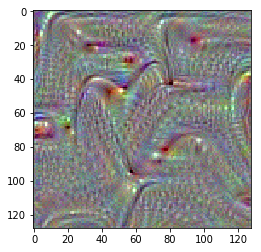

In [23]:
import matplotlib.pyplot as plt

plt.imshow(img)

#### Deep Dream

In [29]:
from __future__ import print_function

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

#parser = argparse.ArgumentParser(description='Deep Dreams with Keras.')
#parser.add_argument('base_image_path', metavar='base', type=str,
                   # help='Path to the image to transform.')
#parser.add_argument('result_prefix', metavar='res_prefix', type=str,
                    #help='Prefix for the saved results.')

#args = parser.parse_args()
base_image_path = "data/panda.jpg"
result_prefix = "resultado"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


"""Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""


# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

#save_img(result_prefix + '.png', deprocess_image(np.copy(img)))

87916544/87910968 [==============================] - 99s 1us/step
Model loaded.
Processing image shape (587, 1044)
..Loss value at 0 : 0.80953825
..Loss value at 1 : 1.0545578
..Loss value at 2 : 1.4285609
..Loss value at 3 : 1.8386062
..Loss value at 4 : 2.2700834
..Loss value at 5 : 2.7040374
..Loss value at 6 : 3.1104946
..Loss value at 7 : 3.515183
..Loss value at 8 : 3.8940063
..Loss value at 9 : 4.275843
..Loss value at 10 : 4.6467004
..Loss value at 11 : 4.977759
..Loss value at 12 : 5.3240957
..Loss value at 13 : 5.6564384
..Loss value at 14 : 5.96484
..Loss value at 15 : 6.2681227
..Loss value at 16 : 6.584202
..Loss value at 17 : 6.876272
..Loss value at 18 : 7.18659
..Loss value at 19 : 7.458724
Processing image shape (822, 1462)
..Loss value at 0 : 1.8617
..Loss value at 1 : 2.8539023
..Loss value at 2 : 3.5895815
..Loss value at 3 : 4.169574
..Loss value at 4 : 4.7020483
..Loss value at 5 : 5.1850057
..Loss value at 6 : 5.6523495
..Loss value at 7 : 6.0768905
..Loss value 

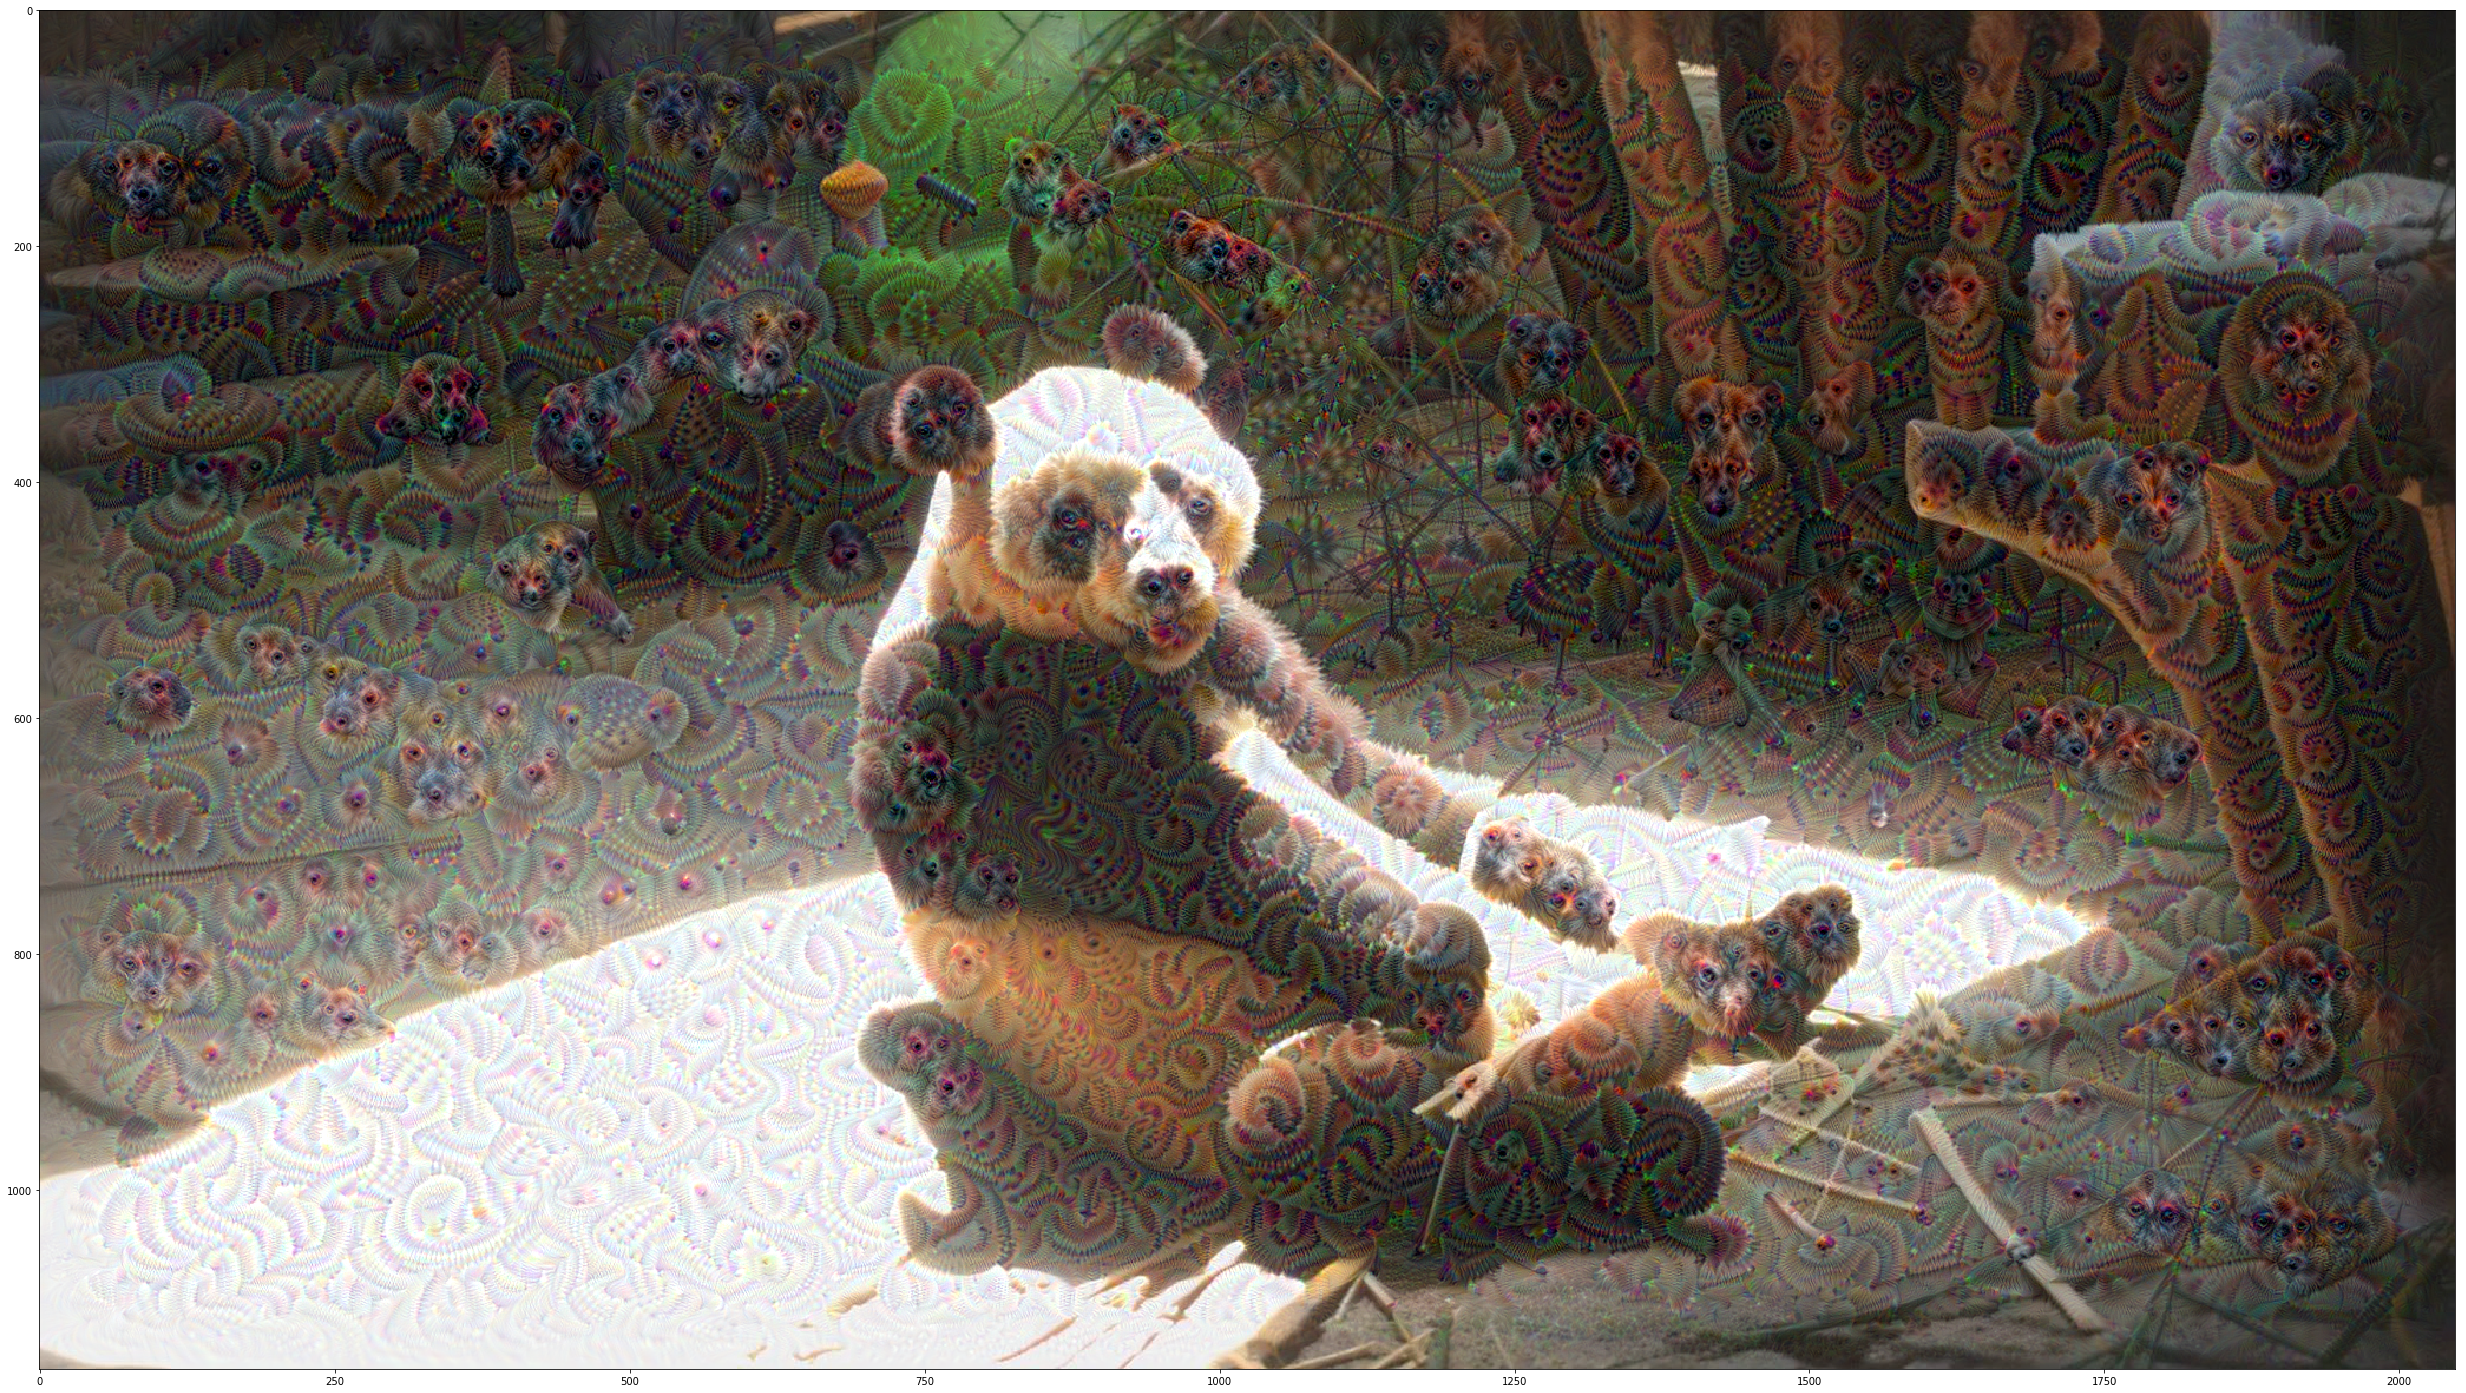

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50,25))
plt.imshow(deprocess_image(np.copy(img)))

## References 

+ Convolutional Neural Networks. Udacity
+ https://iamaaditya.github.io/2016/03/one-by-one-convolution/
+ http://cs231n.github.io/convolutional-networks/#layers
+ https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
+ https://github.com/keras-team/keras/blob/master/examples/deep_dream.py